In [79]:
import os
import shutil
import time


import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn import Conv2d, LeakyReLU, InstanceNorm2d, BatchNorm2d
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms as T

import warnings
warnings.filterwarnings("ignore")

In [46]:
MONET_DIR = '../../monet_jpg/'
PHOTO_DIR = '../../photo_jpg/'
SAVE_PATH = '../../images/'

RADNOM_STATE = 12345
IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [83]:
torch.manual_seed(RADNOM_STATE)

In [47]:
device

'cpu'

### Visualization

In [48]:
def unnormalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    
    # To normalize: X_norm = (X - mean) / std
    # To unnormalize: X = (X_norm * std) + mean

    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(s)
        
    return img


def show_images(data):

    fig, ax = plt.subplots(2, 4, figsize=(10, 6))
    
    it = iter(data)
    
    for i in range(4):
        
        p, m = next(it)

        ax[0][i].imshow(unnormalize(p[0]).permute(1,2,0))
        ax[1][i].imshow(unnormalize(m[0]).permute(1,2,0))
        ax[0][i].set_title('Photo')
        ax[1][i].set_title('Monet')

    plt.show()


def plot_train_loss(log):
    
    df = pd.read_csv(log)

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7,6))

    df.plot(x='epoch', y='loss_gen_total_avg', 
            kind='line', ax=ax[0], color='b', label='Total')

    df.plot(x='epoch', y='loss_gen_photo_avg', 
            kind='line', ax=ax[0], color='r', label='Photo Generator')

    df.plot(x='epoch', y='loss_gen_monet_avg', 
            kind='line', ax=ax[0], color='g', label='Monet Generator')


    df.plot(x='epoch', y='loss_disc_total_avg', 
            kind='line', ax=ax[1], color='b', label='Total')

    df.plot(x='epoch', y='loss_disc_photo_avg', 
            kind='line', ax=ax[1], color='r', label='Photo Discriminator')

    df.plot(x='epoch', y='loss_disc_monet_avg', 
            kind='line', ax=ax[1], color='g', label='Monet Discriminator')


    ax[0].set_title('Generator Losses')
    ax[1].set_title('Discriminator Losses')

    ax[0].set_ylabel('Loss')
    ax[1].set_ylabel('Loss')

    plt.tight_layout()
    plt.show()

In [49]:
class ImageDatasetCV(Dataset):
    
    def __init__(self, monet_dir, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        
        self.monet_dir = None
        
        if monet_dir:  
            self.monet_dir = monet_dir
            self.monet_idx = dict()
            for i, filename in enumerate(os.listdir(self.monet_dir)):
                self.monet_idx[i] = filename

        self.photo_dir = photo_dir
        self.photo_idx = dict()
        for i, filename in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = filename
        
        if normalize:
            self.transforms = T.Compose([T.Resize(size), 
                                         T.ToTensor(), 
                                         T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                        ])
            
        else:
            self.transforms = T.Compose([T.Resize(size), 
                                         T.ToTensor()
                                        ])    
            
        
    def __getitem__(self, idx):
        
        random_idx = idx
        
        if self.monet_dir: 
            
            random_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
            
            monet_path = os.path.join(self.monet_dir, self.monet_idx[random_idx])
            monet_img = self.transforms(Image.open(monet_path))
        
        
        photo_path = os.path.join(self.photo_dir, self.photo_idx[random_idx])
        photo_img = self.transforms(Image.open(photo_path))
        
        if self.monet_dir:
            return photo_img, monet_img
        else:
            return photo_img
        
    
    def __len__(self):
        
        if self.monet_dir:
            return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))
        else:
            return len(self.photo_idx.keys())

### Save and Load NN

In [50]:
def save_checkpoint(state, save_path):
    torch.save(state, save_path)


def load_checkpoint(ckpt_path, map_location=None):
    ckpt = torch.load(ckpt_path, map_location=map_location)
    print(f'[*] Loading checkpoint from {ckpt_path} succeed!')
    return ckpt

### Load Data

In [63]:
img_dataset = ImageDatasetCV(monet_dir=MONET_DIR, photo_dir=PHOTO_DIR)
img_dataloader = DataLoader(img_dataset, 
                            batch_size=BATCH_SIZE, 
                            pin_memory=True)

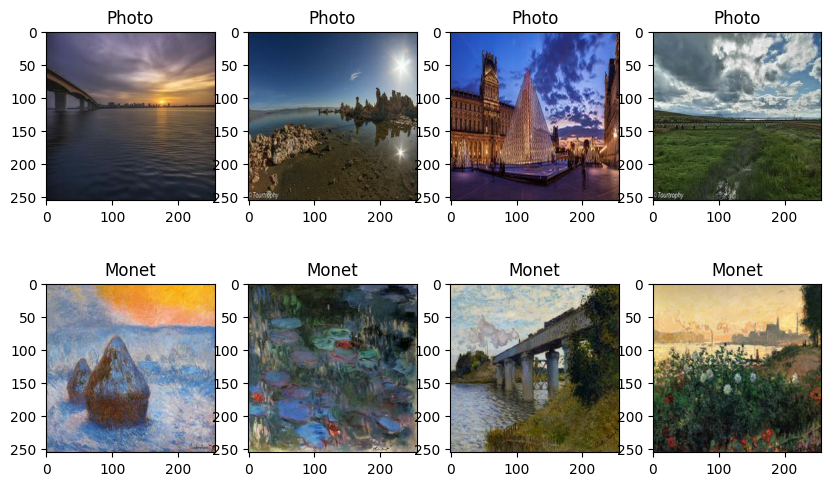

In [64]:
show_images(img_dataloader)

### CycleGAN Model

In [65]:
def Convlayer(in_ch, out_ch, kernel_size, stride, 
              actv, norm, use_pad=True):
    # Convolution
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)
        
    # Activation Function
    # if use_leaky:
    #     actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    # else:
    #     actv = nn.GELU()
        
    # Normalization
    # if use_inst_norm:
    #     norm = nn.InstanceNorm2d(out_ch)
    # else:
    #     norm = nn.BatchNorm2d(out_ch)
        
    
    return nn.Sequential(conv, 
                         norm, 
                         actv)

In [66]:
def Upsample(in_ch, out_ch, use_dropout=False, dropout_ratio=0.5):
    
    # Transposed Convolution
    convtrans = nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1)
    
    # Normalization
    norm = nn.InstanceNorm2d(out_ch)
    
    # Activatin Function
    actv = nn.GELU()
    
    
    if use_dropout:
        
        # Dropout layer
        drop = nn.Dropout(dropout_ratio)
        
        return nn.Sequential(convtrans, 
                             norm, 
                             drop, 
                             actv)

    else:       
        return nn.Sequential(convtrans, 
                             norm, 
                             actv)
         

In [67]:
class Resblock(nn.Module):
    
    def __init__(self, in_features, use_dropout=False, dropout_ratio=0.5):
        super().__init__()
        
        layers = []
        
        # Padding
        layers.append(nn.ReflectionPad2d(1))
        
        # Convolution layer
        layers.append(Convlayer(in_features, in_features, 3, 1, actv=nn.GELU(), norm=nn.BatchNorm2d(in_features), use_pad=False))
        
        # Dropout
        if use_dropout:
            layers.append(nn.Dropout(dropout_ratio))
        
        # Padding
        layers.append(nn.ReflectionPad2d(1))
        
        # Convolution
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        
        # Normalization
        layers.append(nn.InstanceNorm2d(in_features))
        
        
        self.res = nn.Sequential(*layers)
        
        
    def forward(self, x):
        
        return x + self.res(x)

In [68]:
class Generator(nn.Module):
    
    def __init__(self, in_ch, out_ch, num_res_blocks=6):
        super().__init__()
        model = []
        
        # Padding layer
        model.append(nn.ReflectionPad2d(3))
        
        
        # Convolution input_channels -> 64
        model.append(Convlayer(
                                in_ch=in_ch, out_ch=64, 
                                kernel_size=7, stride=1, 
                                actv=nn.GELU(), 
                                norm=nn.InstanceNorm2d(out_ch), 
                                use_pad=False
        ))
        
        # Convolution 64 -> 128
        model.append(Convlayer(
                                in_ch=64, out_ch=128, 
                                kernel_size=3, stride=2, 
                                actv=nn.GELU(), 
                                norm=nn.InstanceNorm2d(out_ch),
                                use_pad=True
        ))
        
        # Convolution 128 -> 256
        model.append(Convlayer(
                                in_ch=128, out_ch=256, 
                                kernel_size=3, stride=2, 
                                actv=nn.GELU(), 
                                norm=nn.InstanceNorm2d(out_ch),
                                use_pad=True
        ))
        
        # Residual Block
        for _ in range(num_res_blocks):
            model.append(Resblock(in_features=256))

            
        # Transposed convolution 256 -> 128
        model.append(Upsample(in_ch=256, out_ch=128))  
        
        # Transposed convolution 128 -> 64
        model.append(Upsample(in_ch=128, out_ch=64))    
        
        # Padding Layer
        model.append(nn.ReflectionPad2d(3))
        
        # Convolutional layer
        model.append(nn.Conv2d(in_channels=64, out_channels=out_ch, 
                               kernel_size=7, padding=0))
        
        # Activation function Tanh
        model.append(nn.Tanh())
        
        self.gen = nn.Sequential(*model)
        
        
    def forward(self, x):
        
        return self.gen(x)

In [69]:
class Discriminator(nn.Module):
    
    def __init__(self, in_ch, num_layers=4):
        super().__init__()
        model = []
        
        # Convolution in_channels -> 64
        model.append(nn.Conv2d(in_channels=in_ch, out_channels=64, 
                               kernel_size=4, stride=2, padding=1))
        
        
        # Convolutions i=1:  64 -> 64 
        #              i=2:  64 -> 128
        #              i=3: 128 -> 256 
        #              i=4: 256 -> 512   
        
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            
            if i == num_layers - 1:
                model.append(Convlayer(
                                        in_chs, out_chs, 
                                        kernel_size=4, stride=1,
                                        actv=nn.GELU(), 
                                        norm=nn.InstanceNorm2d(out_chs), 
                ))
                
            else:
                model.append(Convlayer(
                                        in_chs, out_chs, 
                                        kernel_size=4, stride=2,
                                        actv=nn.GELU(), 
                                        norm=nn.InstanceNorm2d(out_chs), 
                ))
        
        # Convolution 512 -> 1
        model.append(nn.Conv2d(in_channels=512, out_channels=1, 
                               kernel_size=4, stride=1, padding=1))
        
        self.disc = nn.Sequential(*model)
        
        
    def forward(self, x):
        
        return self.disc(x)
        

### CycleGAN

In [84]:
class CycleGAN(object):
    
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=0.01, lmbda=10, idt_coef=0.5, decay_epoch=0):
        
        # Regularization coefficients
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        
        # Set device
        self.device = device
        
        # Generator Monet -> Photo
        self.gen_mtp = Generator(in_ch, out_ch)
        
        # Generator Photo -> Monet
        self.gen_ptm = Generator(in_ch, out_ch)
        
        # discriminator for Monet-generated images
        self.disc_m = Discriminator(in_ch)
        
        # discriminator for Photo-generated images
        self.disc_p = Discriminator(in_ch)
        
        # Initialize model weights
        self.init_models()
        
        # Optimizator for generators
        self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), 
                                                         self.gen_ptm.parameters()), 
                                         lr=start_lr, betas=(0.9, 0.999))
        
        # Optimizator for discriminator
        self.adam_disc = torch.optim.Adam(itertools.chain(self.disc_m.parameters(), 
                                                          self.disc_p.parameters()), 
                                         lr=start_lr, betas=(0.9, 0.999))
        
        # Set number of epochs and start of learning rate decay 
        self.epochs = epochs
        
        # Set decay epoch 
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        
        # Set rule for learning step decay
        lambda_decay = lambda epoch: start_lr/(epoch-self.decay_epoch) if epoch > self.decay_epoch else start_lr

        
        # Define scheduler for generator and discriminator
        self.scheduler_gen = torch.optim.lr_scheduler.LambdaLR(self.adam_gen, lr_lambda=lambda_decay)
        self.scheduler_disc = torch.optim.lr_scheduler.LambdaLR(self.adam_disc, lr_lambda=lambda_decay)

    
    # Initialize weights
    def init_weights(self, net, gain=0.02):

        def init_func(m):

            # Name of the class
            classname = m.__class__.__name__

            # If class has attribute "weight" (to initialize) and 
            # has either convolutional layer or linear 
            if hasattr(m, 'weight') and \
               (classname.find('Conv') != -1 or classname.find('Linear') != -1):

                # Initialize weights with values drawn from normal distribution N(mean, std)
                init.normal_(m.weight.data, mean=0.0, std=gain)

                # Set bias value with constant val
                if hasattr(m, 'bias') and m.bias is not None:
                    init.constant_(m.bias.data, val=0.0)

            # Initialize BatchNorm weights
            elif classname.find('BatchNorm2d') != -1:

                init.normal_(m.weight.data, mean=1.0, std=gain)
                init.constant_(m.bias.data, val=0.0)

        # Apply weight initialization to every submodule of model
        net.apply(init_func)
            
    
    # Initialize models
    def init_models(self):
        
        # Initialize weights
        self.init_weights(self.gen_mtp)
        self.init_weights(self.gen_ptm)
        self.init_weights(self.disc_m)
        self.init_weights(self.disc_p)
        
        # Set device for models
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.disc_m = self.disc_m.to(self.device)
        self.disc_p = self.disc_p.to(self.device)        
        
        
        
    # Enable/ disable gradients for model parameters
    def param_require_grad(self, models, requires_grad=True):
        for model in models:
            for param in model.parameters():
                param.requires_grad = requires_grad

        
    # Cycle generation: x -> y_gen -> x_cycle
    def cycle_gen(self, x, G_x_to_y, G_y_to_x):

        y_gen = G_x_to_y(x)
        x_cycle = G_y_to_x(y_gen)

        return y_gen, x_cycle    
    
    
    # Define BCE logistic loss
    def mse_loss(self, x, target):
        
        if target == 1:
            return nn.MSELoss()(x, torch.ones(x.size()).to(self.device))
        else:
            return nn.MSELoss()(x, torch.zeros(x.size()).to(self.device))
    
    
    # Define Generator Loss
    def loss_gen(self, idt, real, cycle, disc):
        
        
        # Identity Losses:
        loss_idt = nn.L1Loss()(idt, real) * self.lmbda * self.idt_coef
        
        # Cycle Losses:
        loss_cycle = nn.L1Loss()(cycle, real) * self.lmbda
        
        # Adversarial Losses:                
        loss_adv = self.mse_loss(disc, target=1)
        
        # Total Generator loss:
        loss_gen = loss_cycle + loss_adv + loss_idt
        
        return loss_gen
    

    # Discriminator Loss
    # Ideal Discriminator will classify real image as 1 and fake as 0
    def loss_disc(self, real, gen):

        loss_real = self.mse_loss(real, target=1)
        loss_gen = self.mse_loss(gen, target=0)

        return (loss_real + loss_gen)/2
    
    
    # Train
    def train(self, img_dl):
        
        history = []
        dataset_len = img_dl.__len__()
        print_header = True
        
        for epoch in tqdm(range(self.epochs)):
            
            # Start measuring time for epoch
            start_time = time.time()

            
            # Nulify average losses for an epoch
            loss_gen_photo_avg = 0.0
            loss_gen_monet_avg = 0.0
            loss_gen_total_avg = 0.0
            
            loss_disc_photo_avg = 0.0
            loss_disc_monet_avg = 0.0
            loss_disc_total_avg = 0.0
            
            
            # Iterate through dataloader with images
            for photo_real, monet_real in img_dl:

                photo_real, monet_real = photo_real.to(device), monet_real.to(device)

                
                # Disable gradients for discriminators during generator training                
                self.param_require_grad([self.disc_m, self.disc_p], requires_grad=False) 

                # Set gradients for generators to zero at the start of the training pass 
                self.adam_gen.zero_grad()


                # =======================================

                # FORWARD PASS THROUGH GENERATOR

                # ----------- Cycle photo ---------------

                monet_gen, photo_cycle = self.cycle_gen(photo_real, 
                                                        self.gen_ptm, 
                                                        self.gen_mtp)
                
                # ----------- Cycle Monet ---------------

                photo_gen, monet_cycle = self.cycle_gen(monet_real, 
                                                        self.gen_mtp, 
                                                        self.gen_ptm)



                # ----------- Generate itself ---------------

                
                # Real Monet -> Identical Monet
                monet_idt = self.gen_ptm(monet_real)      
                
                # Real photo -> Identical photo
                photo_idt = self.gen_mtp(photo_real)

    
                # =======================================

                # DISCRIMINATOR PRECTION ON GENERATED IMAGES


                # Discriminator M: Check generated Monet 
                monet_disc = self.disc_m(monet_gen)

                # Discriminator P: Check generated photo
                photo_disc = self.disc_p(photo_gen)


                # =======================================

                # CALCULATE LOSSES FOR GENERATORS

                # Generator Losses
                loss_gen_photo = self.loss_gen(photo_idt, photo_real, photo_cycle, photo_disc)
                loss_gen_monet = self.loss_gen(monet_idt, monet_real, monet_cycle, monet_disc)
                
                
                # Total Generator loss:
                loss_gen_total = loss_gen_photo + loss_gen_monet
            
            
                # Update average Generator loss:
                loss_gen_photo_avg += loss_gen_photo.item()
                loss_gen_monet_avg += loss_gen_monet.item()
                loss_gen_total_avg += loss_gen_total.item()

                
                # =======================================

                # GENERATOR BACKWARD PASS 


                # Propagate loss backward
                loss_gen_total.backward()

                # Make step with optimizer
                self.adam_gen.step()

                
                # =======================================

                # FORWARD PASS THROUGH DISCRIMINATORS

                
                # Enable gradients for discriminators during discriminator trainig
                self.param_require_grad([self.disc_m, self.disc_p], requires_grad=True) 
                
                # Set zero gradients
                self.adam_disc.zero_grad()
                
                
                # discriminator M: Predictions on real and generated Monet:
                monet_disc_real = self.disc_m(monet_real)
                monet_disc_gen = self.disc_m(monet_gen.detach())

                # discriminator P: Predictions on real and generated photo:
                photo_disc_real = self.disc_p(photo_real)
                photo_disc_gen = self.disc_p(photo_gen.detach())

       
                # =======================================

                # CALCULATE LOSSES FOR DISCRIMINATORS

                # Discriminator losses
                loss_disc_photo = self.loss_disc(photo_disc_real, photo_disc_gen)
                loss_disc_monet = self.loss_disc(monet_disc_real, monet_disc_gen)


                # Total discriminator loss:                
                loss_disc_total = loss_disc_photo + loss_disc_monet

                
                # =======================================

                # DISCRIMINATOR BACKWARD PASS 


                # Propagate losses backward
                loss_disc_total.backward()
                
                # Make step with optimizer
                self.adam_disc.step()
                

                # =======================================

                # Update average Discriminator loss
                loss_disc_photo_avg += loss_disc_photo.item()
                loss_disc_monet_avg += loss_disc_monet.item()
                loss_disc_total_avg += loss_disc_total.item()
                
                
            # Calculate average losses per epoch 
            loss_gen_photo_avg /= dataset_len
            loss_gen_monet_avg /= dataset_len
            loss_gen_total_avg /= dataset_len
            
            loss_disc_photo_avg /= dataset_len
            loss_disc_monet_avg /= dataset_len
            loss_disc_total_avg /= dataset_len
            
            
            # Estimate training time per epoch
            time_req = time.time() - start_time
            
            # Expand training history
            history.append([
                            epoch,
                            loss_gen_photo_avg, 
                            loss_gen_monet_avg, 
                            loss_gen_total_avg,
                            loss_disc_photo_avg, 
                            loss_disc_monet_avg, 
                            loss_disc_total_avg
                            ])
            
            
            # Print statistics
            if print_header:
                print('EPOCH | LOSS: Gen photo | Gen Monet | Disc photo | Disc Monet | TIME MIN')
                print_header = False
                
            print('------+-----------------+-----------+------------+------------+----------')
            print('  {:3} |        {:>8.2f} |  {:>8.2f} |   {:>8.2f} |   {:>8.2f} |     {:4.0f}'.format(epoch+1, 
                                                                                        loss_gen_photo_avg, 
                                                                                        loss_gen_monet_avg, 
                                                                                        loss_disc_photo_avg, 
                                                                                        loss_disc_monet_avg, 
                                                                                        time_req//60))
            # Step learning rate scheduler
            self.scheduler_gen.step()
            self.scheduler_disc.step()

        # Save training history
        history = pd.DataFrame(history, columns=['epoch',  
                                                 'loss_gen_photo_avg', 
                                                 'loss_gen_monet_avg', 
                                                 'loss_gen_total_avg',
                                                 'loss_disc_photo_avg', 
                                                 'loss_disc_monet_avg', 
                                                 'loss_disc_total_avg' ])
        
        history.to_csv('history.csv', index=False)
        
        
    def predict(self, image):
        with torch.no_grad():
            self.gen_ptm.eval()           
            image = image.to(self.device)
            monet_gen = self.gen_ptm(image)
        
        return monet_gen

### Train

In [87]:
gan = CycleGAN(3, 3, epochs=1, device=device)

In [88]:
gan.train(img_dataloader)

  0%|          | 0/1 [11:15<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plot_train_loss(log='history.csv')

In [ ]:
photo_dataset = ImageDatasetCV(monet_dir=None, photo_dir=PHOTO_DIR)
photo_dataloader = DataLoader(photo_dataset, batch_size=BATCH_SIZE)

In [ ]:
with torch.no_grad():
    j = 0
    for photo in photo_dataloader:
        photo = photo.to(device)
        monet_gen = gan.gen_ptm(photo)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))
        ax[0].imshow(unnormalize(photo[0].cpu()).permute(1,2,0))
        ax[1].imshow(unnormalize(monet_gen[0].cpu().detach()).permute(1,2,0))
        ax[0].set_title('Photo')
        ax[1].set_title('Monetesque photo')
        
        plt.show()
        j += 1
        if j > 3:
            break
            

### Save Results

In [ ]:
save_dict = {
    'epoch': 0,
    'gen_mtp': gan.gen_mtp.state_dict(),
    'gen_ptm': gan.gen_ptm.state_dict(),
    'desc_m': gan.disc_m.state_dict(),
    'desc_p': gan.disc_p.state_dict(),
    'optimizer_gen': gan.adam_gen.state_dict(),
    'optimizer_desc': gan.adam_disc.state_dict()
}

In [ ]:
save_checkpoint(save_dict, 'model.ckpt')

In [ ]:
# !mkdir ../images

In [ ]:

with torch.no_grad(): 
    for i, photo in enumerate(photo_dataloader):
        monet_gen = gan.predict(photo)
        monet_gen = T.ToPILImage()(unnormalize(monet_gen[0].cpu().detach())).convert('RGB')
        monet_gen.save(SAVE_PATH + str(i+1) + ".jpg")

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")